In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-334ce787-4291-fc81-c849-31a66c3f7a64)


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
ROOT_DIR = "/content/gdrive/MyDrive/Brats_dataset"
import os
os.listdir(ROOT_DIR)

TRAIN_DATA_PATH = os.path.join(ROOT_DIR, "MICCAI_BraTS2020_TrainingData")

In [ ]:
from tqdm import tqdm
import os


import numpy as np

import nibabel as nib
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import backend as K

from tensorflow.keras import Input
from tensorflow.keras import initializers

from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose, 
    BatchNormalization, 
    Activation, 
    MaxPooling2D, 
    UpSampling2D, 
    concatenate, 
    Add,
    Dropout)



from skimage.transform import resize
from skimage import exposure
import cv2

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model, load_model

%matplotlib inline


In [ ]:
def read_image(path):
    image = nib.load(path)
    image = (image.dataobj)
    return np.asarray(image)

In [ ]:
import random
def show_slice(case: str, mode: str, slice_: int = None):
  """
  case : str, three digit index from 001 to 369
  slice_: int, integer slice index ranging from 0 to 154
  mode: str, mode of image, can be one of the five following types (case sensitive)
  - flair
  - t1
  - t1ce
  - t2
  - seg
  """
  case_path = os.path.join(TRAIN_DATA_PATH, f'BraTS20_Training_{case}')
  voxel_path = os.path.join(case_path, f'BraTS20_Training_{case}_{mode}.nii.gz')
  voxel = read_image(voxel_path)
  if slice_ is None: 
    slice_ = random.randint(0, 156)
    
  img = voxel[..., slice_]
  plt.imshow(img, cmap="gray")
  return img


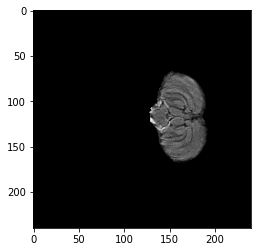

In [ ]:
img = show_slice(case='120', mode='flair', slice_=20)

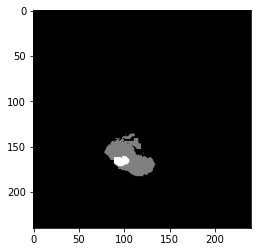

In [ ]:
seg_img = show_slice('250', mode="seg", slice_=42)
plt.imshow(seg_img, cmap="gray")

In [ ]:
"""
n classes = dog, cat, human

image (120 x 120) originally has dog in it

[0.96, 0.02, 0.02]

[1, 0, 0]
multi class classification, softmax

multi label classification, sigmoid

[0.96, 0.89, 0.13] y_pred

[1, 1, 0] y_true


not tumour, enhancing, edema, non-enhancing
[0, 0, 0, 0]
"""

'\nn classes = dog, cat, human\n\nimage (120 x 120) originally has dog in it\n\n[0.96, 0.02, 0.02]\n\n[1, 0, 0]\nmulti class classification, softmax\n\nmulti label classification, sigmoid\n\n[0.96, 0.89, 0.13] y_pred\n\n[1, 1, 0] y_true\n\n\nnot tumour, enhancing, edema, non-enhancing\n[0, 0, 0, 0]\n'

In [ ]:
val, freq = np.unique(seg_img, return_counts=True)


val, freq

(array([0, 2, 4], dtype=uint8), array([56175,  1276,   149]))

In [ ]:
def get_labels(mask):
  total_pixels = 240 * 240
  label_onehot = np.zeros(4)

  val, freq = np.unique(mask, return_counts=True)
  if (0 in val) and (freq[0] == total_pixels):  # check if the unique values contain 0
    label_onehot[0] = 1
  else:
    # print(val[1:])
    val[ val == 4 ] = 3
    np.put(label_onehot, val[1:], 1)
  return label_onehot

In [ ]:
label = get_labels(seg_img)
label

array([0., 0., 1., 1.])

In [ ]:
INPUT_DIM = (128, 128)

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, spatient_IDs, dim=INPUT_DIM, start_slice = 20, z_range = 120, batch_size = 1, n_channels = 2, n_classes = 4, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = spatient_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.__start_slice = start_slice
        self.__z_range = z_range
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def get_mask(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        mask = self.get_mask_volume(Batch_ids)

        return mask


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size * self.__z_range, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * self.__z_range, self.n_classes))


        
        # Generate data
        # Generate data
        
        # Output is input image (normalized) & label as one-hot vector [a, b, c, d]
        # a --> not tumour (for 0 pixels)
        # b --> necrotic (for 1 pixels)
        # c --> edema (for 2 pixels)
        # d --> enhancing (for 4 pixels)


        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATA_PATH, i)

            flair_path = os.path.join(case_path, f'{i}_flair.nii.gz')
            flair = read_image(flair_path)      

            # t1_path = os.path.join(case_path, f'{i}_t1.nii.gz')
            # t1 = read_image(t1_path)

            t1ce_path = os.path.join(case_path, f'{i}_t1ce.nii.gz')
            ce = read_image(t1ce_path)
            
            # t2_path = os.path.join(case_path, f'{i}_t2.nii.gz')
            # t2 = read_image(t2_path)

            seg_path = os.path.join(case_path, f'{i}_seg.nii.gz')
            seg = read_image(seg_path)
        
            for j in range(self.__z_range):
                X[j + self.__z_range * c, :, :, 0] = cv2.resize(flair[:, :, j + self.__start_slice], self.dim)

                X[j + self.__z_range * c, :, :, 1] = cv2.resize(ce[:, :, j + self.__start_slice], self.dim)

                # y[j + self.__z_range * c] = seg[:, :, j + self.__start_slice]
                seg_img = seg[:, :, j + self.__start_slice]
                y[j + self.__z_range * c] = get_labels(seg_img) 
                    
            #=============Preprocess masks===========
        

        # X = cv2.normalize(X, None, alpha=0, beta=255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        return X/np.max(X), y

    def get_mask_volume(self, Batch_ids):
        Y_mask = np.zeros((self.batch_size * self.__z_range, *self.dim))
        for c, i in enumerate(Batch_ids):

          case_path = os.path.join(TRAIN_DATA_PATH, i)

          seg_path = os.path.join(case_path, f'{i}_seg.nii.gz')
          seg = read_image(seg_path)

          for j in range(self.__z_range):
            Y_mask[j + self.__z_range * c] = cv2.resize(seg[:, :, j + self.__start_slice], self.dim)
          
        Y_mask[Y_mask == 4] = 3
        return Y_mask

In [ ]:
from sklearn.model_selection import train_test_split
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATA_PATH) if f.is_dir()]
# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(os.path.join(TRAIN_DATA_PATH, 'BraTS20_Training_355'))


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

train_val_ids, test_ids = train_test_split(train_and_test_ids,test_size=0.15, shuffle=True) 
train_ids, val_ids = train_test_split(train_val_ids,test_size=0.2, shuffle=True) 

print(f"train size: {len(train_ids)}, validation size: {len(val_ids)}, test size: {len(test_ids)}")

train size: 249, validation size: 63, test size: 56


In [ ]:
train_gen = DataGenerator(train_ids)
valid_gen = DataGenerator(val_ids)
test_gen = DataGenerator(test_ids)

In [ ]:
X, y = train_gen[2]

y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],


[0. 1. 2.]


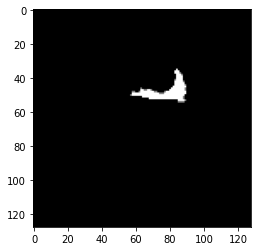

In [ ]:
seg_og = train_gen.get_mask(6)

plt.imshow(seg_og[62, ...], cmap="gray")
print(np.unique(seg_og[62, ...]))

In [ ]:
get_labels(seg_og[62, ...].astype('int32'))

array([0., 1., 1., 0.])

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50

K.clear_session()

vgg16 = VGG16(weights=None, input_shape=(128, 128, 2), classes=4, classifier_activation='sigmoid')
# resnet = ResNet50(weights=None, input_shape=(128, 128, 2), classes=4, classifier_activation='sigmoid')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/applications/imagenet_utils.py:333: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  str(input_shape[-1]) + ' input channels.')


In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 2)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1216      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
def plot_model(model_obj: tf.keras.Model, filename: str):
    return tf.keras.utils.plot_model(
        model_obj,
        to_file=filename,
        show_shapes=True,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=70,
    )

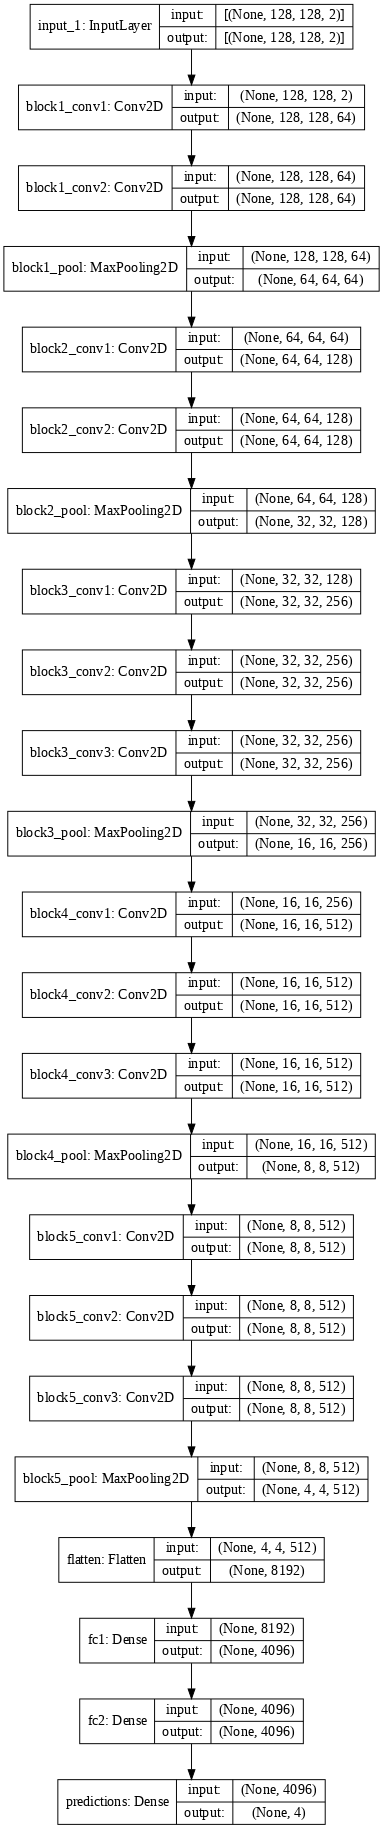

In [ ]:
plot_model(vgg16, filename="vgg16.png")

In [ ]:
vgg16.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-05),  #  5 * 10^-5
                    loss = 'binary_crossentropy', 
                    metrics = ["accuracy"]
)

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger('training_vggnet.csv', separator=',', append=False)
checkpoint_filepath = 'vggnet_first.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint( 
    filepath=checkpoint_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

callbacks = [
    ReduceLROnPlateau(monitor="val_accuracy", patience=2, factor=0.2, verbose=1, min_lr=1e-06),
    csv_logger,
    model_checkpoint
]

In [ ]:
X, y = train_gen[0]

pred = vgg16.predict(X)

In [ ]:
pred

array([[0.49996448, 0.5000023 , 0.49998593, 0.4999832 ],
       [0.4999653 , 0.5000042 , 0.49998575, 0.4999839 ],
       [0.49997067, 0.50000054, 0.49997932, 0.49998015],
       [0.49996233, 0.5000002 , 0.49997902, 0.4999798 ],
       [0.49996156, 0.50000066, 0.4999798 , 0.4999805 ],
       [0.49996626, 0.5000016 , 0.4999801 , 0.49998313],
       [0.4999634 , 0.50000274, 0.4999801 , 0.4999832 ],
       [0.4999652 , 0.50000334, 0.4999826 , 0.4999799 ],
       [0.4999653 , 0.5000062 , 0.4999798 , 0.49997872],
       [0.49995983, 0.5000143 , 0.49997854, 0.49997765],
       [0.49995816, 0.5000239 , 0.49998146, 0.4999799 ],
       [0.49994147, 0.5000268 , 0.4999926 , 0.49997222],
       [0.49993396, 0.50002486, 0.49999338, 0.49997234],
       [0.4999262 , 0.5000284 , 0.49999952, 0.49996674],
       [0.49992597, 0.50003237, 0.49999523, 0.49996865],
       [0.49992454, 0.50003356, 0.49998742, 0.49996245],
       [0.49993068, 0.500039  , 0.4999888 , 0.4999578 ],
       [0.49992615, 0.50003594,

In [ ]:
results = vgg16.fit(
    train_gen,
    epochs=10,
    steps_per_epoch=len(train_ids),  
    validation_data = valid_gen,
    callbacks= callbacks
)

Epoch 1/10
249/249 [==============================] - 172s 686ms/step - loss: 0.5812 - accuracy: 0.3990 - val_loss: 0.5500 - val_accuracy: 0.4440
Epoch 2/10
249/249 [==============================] - 151s 604ms/step - loss: 0.5433 - accuracy: 0.4399 - val_loss: 0.5047 - val_accuracy: 0.4931
Epoch 3/10
249/249 [==============================] - 150s 602ms/step - loss: 0.5311 - accuracy: 0.4352 - val_loss: 0.5525 - val_accuracy: 0.4045
Epoch 4/10
249/249 [==============================] - 149s 599ms/step - loss: 0.5321 - accuracy: 0.4290 - val_loss: 0.5083 - val_accuracy: 0.4348

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 5/10
249/249 [==============================] - 149s 597ms/step - loss: 0.5155 - accuracy: 0.4302 - val_loss: 0.5003 - val_accuracy: 0.4571
Epoch 6/10
249/249 [==============================] - 149s 599ms/step - loss: 0.5135 - accuracy: 0.4369 - val_loss: 0.4943 - val_accuracy: 0.4873

Epoch 00006: ReduceLROnPlateau reducing le

In [ ]:
vgg16.save_weights("vgg16_first.h5")

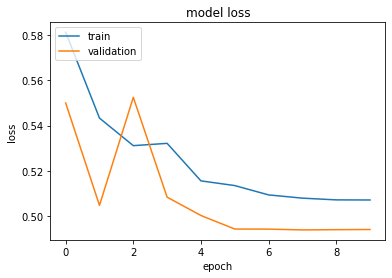

In [ ]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

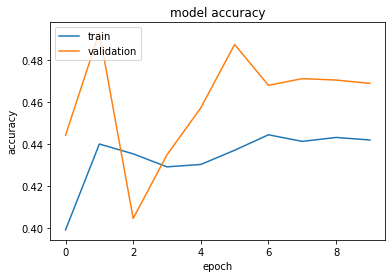

In [ ]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()